In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Đọc dữ liệu từ file CSV
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")

In [3]:
# Chọn các tính năng và loại bỏ biến mục tiêu nếu nó đã được bao gồm trong dữ liệu
X = matches_df.drop(['result'], axis=1)

## Chuẩn Hóa Dữ Liệu

In [4]:
# Xác định các cột phân loại và cột số
categorical_cols = ['venue', 'season']
numerical_cols = [col for col in X if col not in categorical_cols]

In [5]:
# Tiền xử lý các cột phân loại
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num', StandardScaler(), numerical_cols),
    ]
)

In [6]:
X_transformed = preprocessor.fit_transform(X)

#### Áp dụng K-means.

In [7]:
# Chọn số lượng cụm
k = 3  # Có thể thay đổi số này sau khi phân tích (ví dụ: sử dụng phương pháp Elbow)

# Phân cụm
kmeans = KMeans(n_clusters=k, random_state=42)
matches_df['Cluster'] = kmeans.fit_predict(X_transformed)


### Trực quan hóa

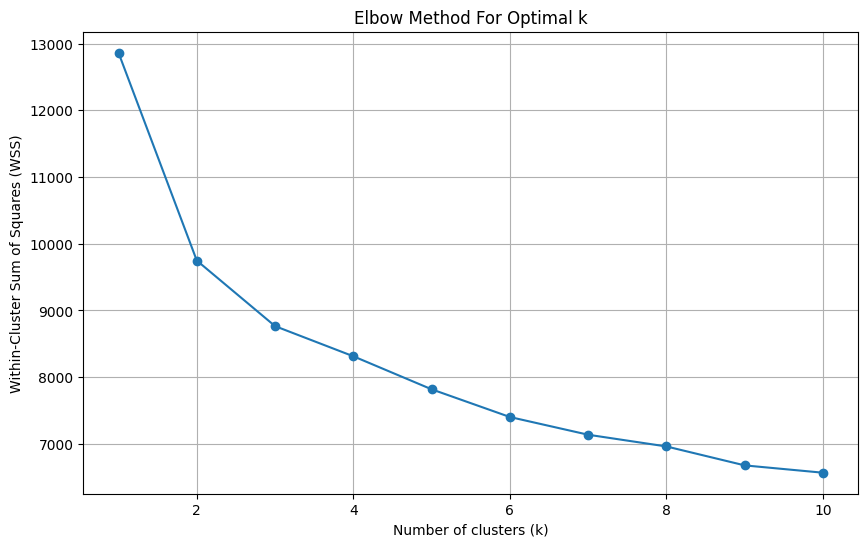

In [8]:
# Tính WSS cho một phạm vi số cụm từ 1 đến 10
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_transformed)
    wss.append(kmeans.inertia_)  # inertia_ là thuộc tính chứa tổng bình phương khoảng cách

# Vẽ đồ thị Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

In [9]:
numeric_cols = matches_df.select_dtypes(include=[np.number])

# Tính toán thống kê mô tả cho các cột số, nhóm theo 'Cluster'
cluster_description = numeric_cols.groupby(matches_df['Cluster']).agg(['mean', 'median', 'std', 'min', 'max'])

print(cluster_description)

        win_percent_before_team2                            win_percent_diff  \
                            mean median       std  min  max             mean   
Cluster                                                                        
0                       0.382317    0.4  0.194585  0.0  1.0         0.060417   
1                       0.161355    0.2  0.142192  0.0  0.5         0.493811   
2                       0.674309    0.6  0.214833  0.0  1.0        -0.139675   

                                    ... average_score_before_match_diff  \
        median       std  min  max  ...                            mean   
Cluster                             ...                                   
0          0.0  0.194952 -0.6  0.5  ...                        0.171900   
1          0.4  0.211924  0.0  1.0  ...                        1.396930   
2         -0.2  0.319851 -1.0  0.6  ...                       -0.363252   

                                   Cluster                      
   

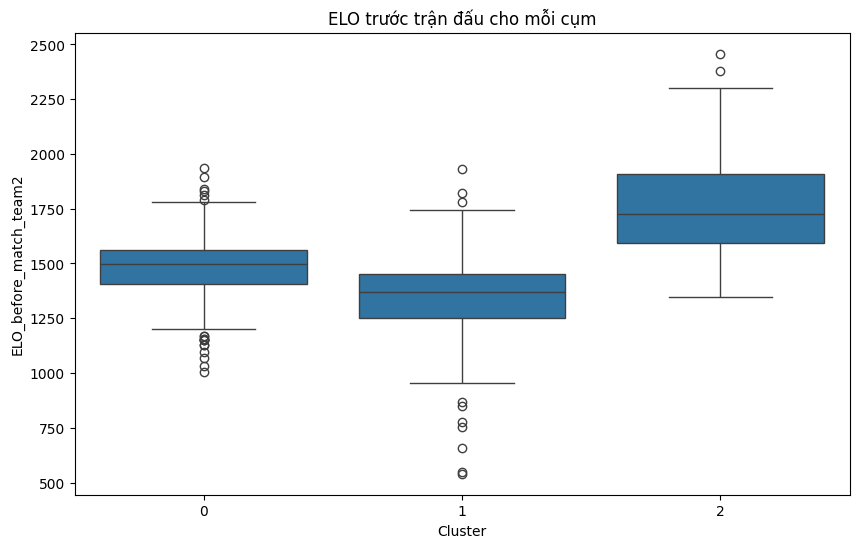

F-value: 379.2662504193242 P-value: 3.087044767161999e-119


In [10]:
# Biểu đồ hộp cho biến 'ELO_before_match_team2'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='ELO_before_match_team2', data=matches_df)
plt.title('ELO trước trận đấu cho mỗi cụm')
plt.show()

# Kiểm định ANOVA cho biến 'ELO_before_match_team2' để xem sự khác biệt giữa các cụm
import scipy.stats as stats

f_value, p_value = stats.f_oneway(matches_df[matches_df['Cluster'] == 0]['ELO_before_match_team2'],
                                  matches_df[matches_df['Cluster'] == 1]['ELO_before_match_team2'],
                                  matches_df[matches_df['Cluster'] == 2]['ELO_before_match_team2'])
print('F-value:', f_value, 'P-value:', p_value)


- Cụm 0: Đối Thủ Yếu
- Cụm 1: Đối Thủ Trung Bình
- Cụm 2: Đối Thủ Mạnh

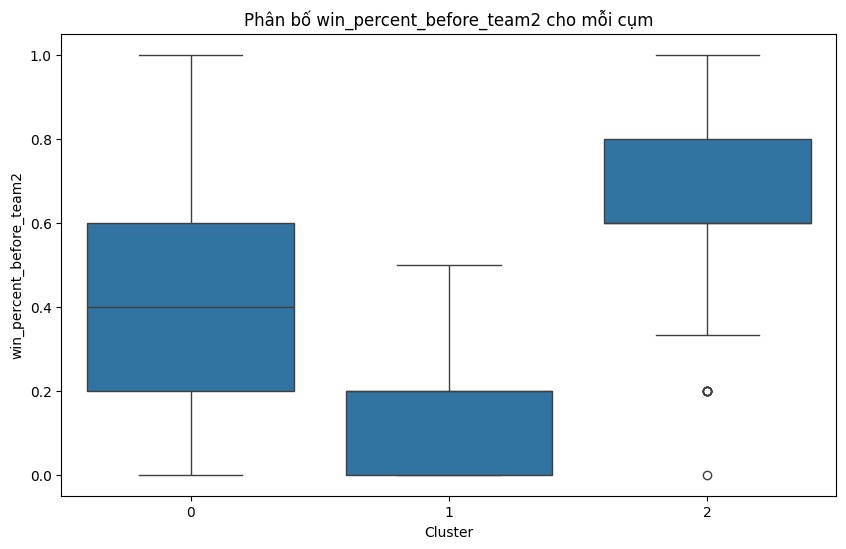

F-Value: 515.0648990784612, P-Value: 2.072442093808888e-148


In [11]:
# Chọn một biến để trực quan hóa
variable = 'win_percent_before_team2'  # Ví dụ: tỷ lệ thắng trước trận

# Biểu đồ hộp cho biến được chọn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=variable, data=matches_df)
plt.title(f'Phân bố {variable} cho mỗi cụm')
plt.show()

# ANOVA test
import scipy.stats as stats
f_val, p_val = stats.f_oneway(matches_df[matches_df['Cluster'] == 0][variable],
                              matches_df[matches_df['Cluster'] == 1][variable],
                              matches_df[matches_df['Cluster'] == 2][variable])
print(f'F-Value: {f_val}, P-Value: {p_val}')


- Cụm 0: Đội có tỷ lệ thắng đa dạng
- Cụm 1: Đội có tỷ lệ thắng thấp
- Cụm 2: Đội có tỷ lệ thắng cao

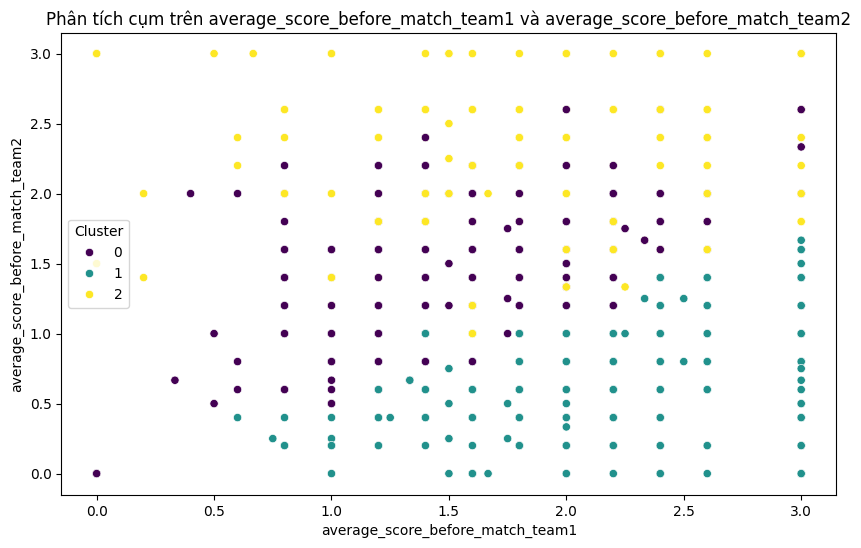

In [12]:
# Chọn hai biến khác để phân tích
var3 = 'average_score_before_match_team1'
var4 = 'average_score_before_match_team2'

# Vẽ biểu đồ phân tán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=var3, y=var4, hue='Cluster', data=matches_df, palette='viridis')
plt.title(f'Phân tích cụm trên {var3} và {var4}')
plt.xlabel(var3)
plt.ylabel(var4)
plt.legend(title='Cluster')
plt.show()


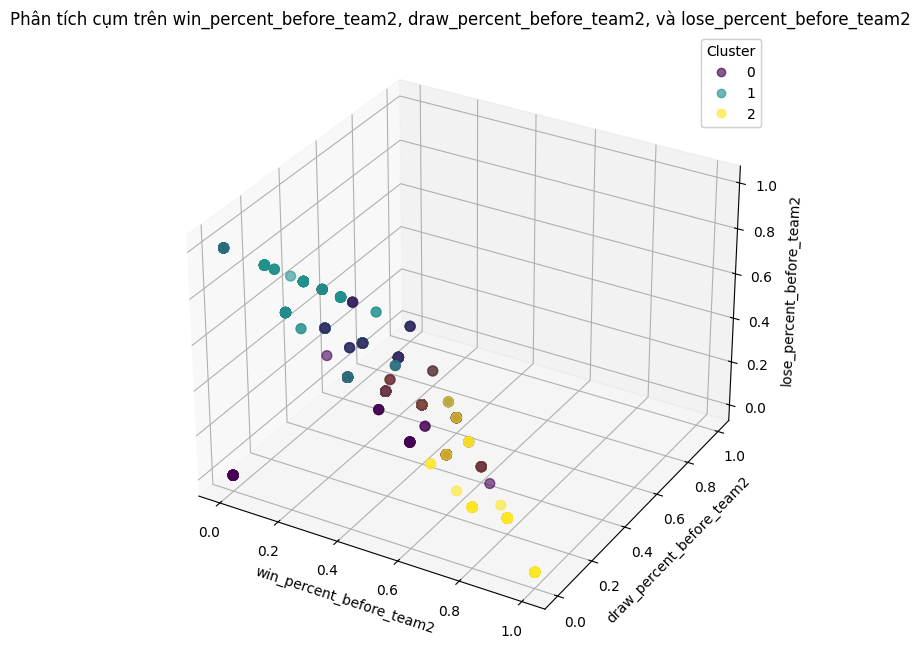

In [13]:
# Chọn ba biến để phân tích
var1 = 'win_percent_before_team2'
var2 = 'draw_percent_before_team2'
var3 = 'lose_percent_before_team2'

# Tạo một figure 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ biểu đồ phân tán 3D
scatter = ax.scatter(matches_df[var1], matches_df[var2], matches_df[var3], c=matches_df['Cluster'], cmap='viridis', s=50, alpha=0.6)

# Đặt nhãn trục và tiêu đề
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.set_zlabel(var3)
plt.title(f'Phân tích cụm trên {var1}, {var2}, và {var3}')

# Thêm legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

plt.show()


- Cụm 0: Đội có thành tích đa dạng
- Cụm 1: Đội có thành tích yếu
- Cụm 2: Đội có thành tích mạnh

In [14]:
import scipy.stats as stats

variables = ['win_percent_before_team2', 'draw_percent_before_team2', 'lose_percent_before_team2']
for var in variables:
    f_val, p_val = stats.f_oneway(
        matches_df[matches_df['Cluster'] == 0][var],
        matches_df[matches_df['Cluster'] == 1][var],
        matches_df[matches_df['Cluster'] == 2][var]
    )
    print(f'{var}: F-Value = {f_val}, P-Value = {p_val}')


win_percent_before_team2: F-Value = 515.0648990784612, P-Value = 2.072442093808888e-148
draw_percent_before_team2: F-Value = 23.634475922476835, P-Value = 1.0097578942349235e-10
lose_percent_before_team2: F-Value = 285.6712629570539, P-Value = 3.802994505557285e-96


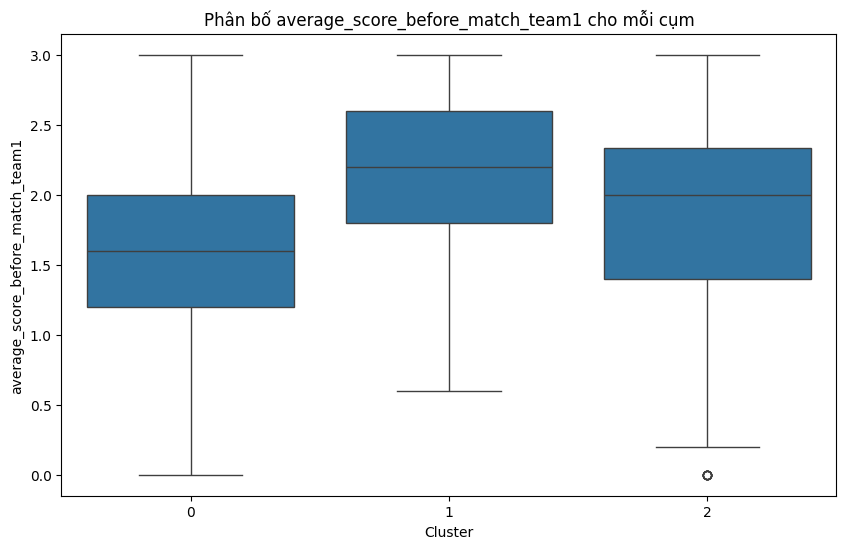

In [15]:
# Ví dụ với average_score_before_match_team1
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='average_score_before_match_team1', data=matches_df)
plt.title('Phân bố average_score_before_match_team1 cho mỗi cụm')
plt.show()


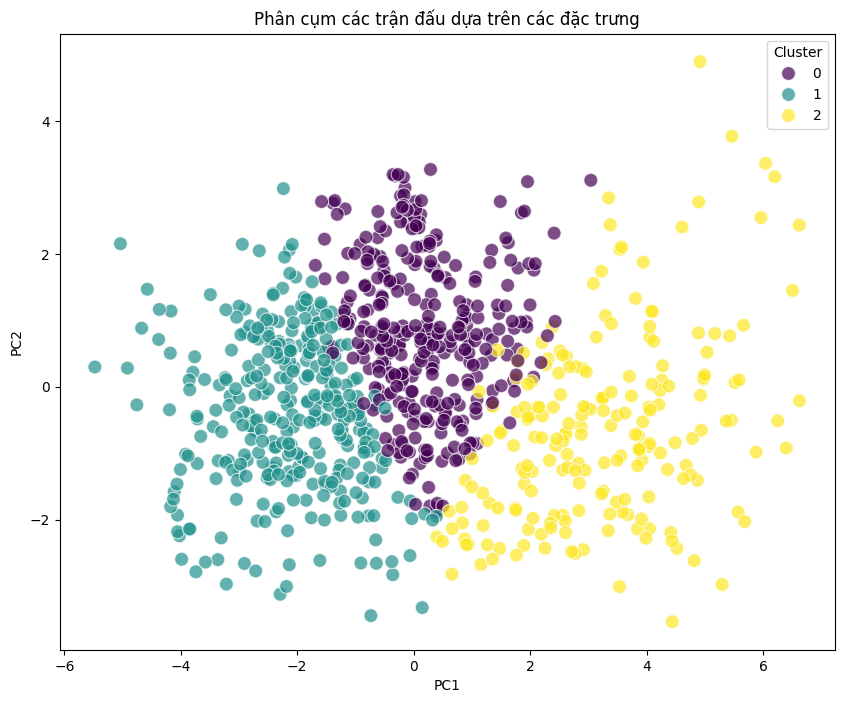

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Giảm chiều dữ liệu xuống 2D để trực quan hóa
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)

# Tạo DataFrame cho việc trực quan hóa
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = matches_df['Cluster']

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, s=100)
plt.title('Phân cụm các trận đấu dựa trên các đặc trưng')
plt.show()


#### Gán nhãn cho từng cụm

In [17]:
# Gán nhãn cho từng cụm
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Weak Opponent'
    elif cluster == 1:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Strong Opponent'
    else:
        return 'Unknown'

# Thêm cột match_type vào DataFrame
matches_df['match_type'] = matches_df['Cluster'].apply(assign_cluster_label)

# Kiểm tra kết quả
print(matches_df[['Cluster', 'match_type']].head())


   Cluster       match_type
0        0    Weak Opponent
1        2  Strong Opponent
2        0    Weak Opponent
3        0    Weak Opponent
4        0    Weak Opponent


In [18]:
# Gán nhãn tỷ lệ thắng cho từng cụm
def assign_win_label(cluster):
    if cluster == 0:
        return 'Diverse Win Rate'
    elif cluster == 1:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'High Win Rate'
    else:
        return 'Unknown'

# Thêm cột win_rate_type vào DataFrame
matches_df['win_rate_type'] = matches_df['Cluster'].apply(assign_win_label)

# Kiểm tra kết quả
print(matches_df[['Cluster', 'match_type', 'win_rate_type']].head())

   Cluster       match_type     win_rate_type
0        0    Weak Opponent  Diverse Win Rate
1        2  Strong Opponent     High Win Rate
2        0    Weak Opponent  Diverse Win Rate
3        0    Weak Opponent  Diverse Win Rate
4        0    Weak Opponent  Diverse Win Rate


In [19]:
# Lưu DataFrame vào một tệp CSV
matches_df.to_csv('asernal_clustered.csv', index=False)